# Sciplex Dose

In [1]:
ood_seed = 0

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('BMS', '5.0'), 193)


Removed datapoint: 193

train         11622
validation     2996
ood             193
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 65%|██████▍   | 9603/14811 [00:00<00:00, 96021.62it/s]

100%|██████████| 14811/14811 [00:00<00:00, 95757.09it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 974475.47it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 156.48it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<29:29,  4.43s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<29:29,  4.43s/it, v_num=1, recon=3.1e+3, r2_mean=0.125, adv_loss=1.5, acc_pert=0.33]

Epoch 2/400:   0%|          | 1/400 [00:04<29:29,  4.43s/it, v_num=1, recon=3.1e+3, r2_mean=0.125, adv_loss=1.5, acc_pert=0.33]

Epoch 2/400:   0%|          | 2/400 [00:07<25:20,  3.82s/it, v_num=1, recon=3.1e+3, r2_mean=0.125, adv_loss=1.5, acc_pert=0.33]

Epoch 2/400:   0%|          | 2/400 [00:07<25:20,  3.82s/it, v_num=1, recon=2.35e+3, r2_mean=0.487, adv_loss=1.25, acc_pert=0.513]

Epoch 3/400:   0%|          | 2/400 [00:07<25:20,  3.82s/it, v_num=1, recon=2.35e+3, r2_mean=0.487, adv_loss=1.25, acc_pert=0.513]

Epoch 3/400:   1%|          | 3/400 [00:11<24:09,  3.65s/it, v_num=1, recon=2.35e+3, r2_mean=0.487, adv_loss=1.25, acc_pert=0.513]

Epoch 3/400:   1%|          | 3/400 [00:11<24:09,  3.65s/it, v_num=1, recon=2.21e+3, r2_mean=0.604, adv_loss=1.13, acc_pert=0.564]

Epoch 4/400:   1%|          | 3/400 [00:11<24:09,  3.65s/it, v_num=1, recon=2.21e+3, r2_mean=0.604, adv_loss=1.13, acc_pert=0.564]

Epoch 4/400:   1%|          | 4/400 [00:14<23:28,  3.56s/it, v_num=1, recon=2.21e+3, r2_mean=0.604, adv_loss=1.13, acc_pert=0.564]

Epoch 4/400:   1%|          | 4/400 [00:14<23:28,  3.56s/it, v_num=1, recon=2.16e+3, r2_mean=0.677, adv_loss=1.03, acc_pert=0.61] 

Epoch 5/400:   1%|          | 4/400 [00:14<23:28,  3.56s/it, v_num=1, recon=2.16e+3, r2_mean=0.677, adv_loss=1.03, acc_pert=0.61]

Epoch 5/400:   1%|▏         | 5/400 [00:19<25:20,  3.85s/it, v_num=1, recon=2.16e+3, r2_mean=0.677, adv_loss=1.03, acc_pert=0.61]

Epoch 5/400:   1%|▏         | 5/400 [00:19<25:20,  3.85s/it, v_num=1, recon=2.14e+3, r2_mean=0.725, adv_loss=0.964, acc_pert=0.636]

Epoch 6/400:   1%|▏         | 5/400 [00:19<25:20,  3.85s/it, v_num=1, recon=2.14e+3, r2_mean=0.725, adv_loss=0.964, acc_pert=0.636]

Epoch 6/400:   2%|▏         | 6/400 [00:22<24:12,  3.69s/it, v_num=1, recon=2.14e+3, r2_mean=0.725, adv_loss=0.964, acc_pert=0.636]

Epoch 6/400:   2%|▏         | 6/400 [00:22<24:12,  3.69s/it, v_num=1, recon=2.13e+3, r2_mean=0.753, adv_loss=0.92, acc_pert=0.652] 

Epoch 7/400:   2%|▏         | 6/400 [00:22<24:12,  3.69s/it, v_num=1, recon=2.13e+3, r2_mean=0.753, adv_loss=0.92, acc_pert=0.652]

Epoch 7/400:   2%|▏         | 7/400 [00:26<25:07,  3.84s/it, v_num=1, recon=2.13e+3, r2_mean=0.753, adv_loss=0.92, acc_pert=0.652]

Epoch 7/400:   2%|▏         | 7/400 [00:26<25:07,  3.84s/it, v_num=1, recon=2.12e+3, r2_mean=0.774, adv_loss=0.898, acc_pert=0.666]

Epoch 8/400:   2%|▏         | 7/400 [00:26<25:07,  3.84s/it, v_num=1, recon=2.12e+3, r2_mean=0.774, adv_loss=0.898, acc_pert=0.666]

Epoch 8/400:   2%|▏         | 8/400 [00:30<24:34,  3.76s/it, v_num=1, recon=2.12e+3, r2_mean=0.774, adv_loss=0.898, acc_pert=0.666]

Epoch 8/400:   2%|▏         | 8/400 [00:30<24:34,  3.76s/it, v_num=1, recon=2.12e+3, r2_mean=0.79, adv_loss=0.88, acc_pert=0.676]  

Epoch 9/400:   2%|▏         | 8/400 [00:30<24:34,  3.76s/it, v_num=1, recon=2.12e+3, r2_mean=0.79, adv_loss=0.88, acc_pert=0.676]

Epoch 9/400:   2%|▏         | 9/400 [00:34<24:51,  3.82s/it, v_num=1, recon=2.12e+3, r2_mean=0.79, adv_loss=0.88, acc_pert=0.676]

Epoch 9/400:   2%|▏         | 9/400 [00:34<24:51,  3.82s/it, v_num=1, recon=2.11e+3, r2_mean=0.806, adv_loss=0.862, acc_pert=0.682]

Epoch 10/400:   2%|▏         | 9/400 [00:34<24:51,  3.82s/it, v_num=1, recon=2.11e+3, r2_mean=0.806, adv_loss=0.862, acc_pert=0.682]


disnt_basal = 0.4001439168204155

disnt_after = 0.401147640508788

val_r2_mean = 0.807433533668518

val_r2_var = 0.28416510125001276


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:53<56:16,  8.66s/it, v_num=1, recon=2.11e+3, r2_mean=0.806, adv_loss=0.862, acc_pert=0.682]

Epoch 10/400:   2%|▎         | 10/400 [00:53<56:16,  8.66s/it, v_num=1, recon=2.11e+3, r2_mean=0.82, adv_loss=0.849, acc_pert=0.683, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:53<56:16,  8.66s/it, v_num=1, recon=2.11e+3, r2_mean=0.82, adv_loss=0.849, acc_pert=0.683, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:57<46:31,  7.18s/it, v_num=1, recon=2.11e+3, r2_mean=0.82, adv_loss=0.849, acc_pert=0.683, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:57<46:31,  7.18s/it, v_num=1, recon=2.11e+3, r2_mean=0.832, adv_loss=0.834, acc_pert=0.698, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:57<46:31,  7.18s/it, v_num=1, recon=2.11e+3, r2_mean=0.832, adv_loss=0.834, acc_pert=0.698, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:00<39:01,  6.04s/it, v_num=1, recon=2.11e+3, r2_mean=0.832, adv_loss=0.834, acc_pert=0.698, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:00<39:01,  6.04s/it, v_num=1, recon=2.1e+3, r2_mean=0.843, adv_loss=0.825, acc_pert=0.696, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [01:00<39:01,  6.04s/it, v_num=1, recon=2.1e+3, r2_mean=0.843, adv_loss=0.825, acc_pert=0.696, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:04<34:28,  5.34s/it, v_num=1, recon=2.1e+3, r2_mean=0.843, adv_loss=0.825, acc_pert=0.696, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:04<34:28,  5.34s/it, v_num=1, recon=2.1e+3, r2_mean=0.849, adv_loss=0.816, acc_pert=0.693, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:04<34:28,  5.34s/it, v_num=1, recon=2.1e+3, r2_mean=0.849, adv_loss=0.816, acc_pert=0.693, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:07<30:23,  4.73s/it, v_num=1, recon=2.1e+3, r2_mean=0.849, adv_loss=0.816, acc_pert=0.693, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:07<30:23,  4.73s/it, v_num=1, recon=2.1e+3, r2_mean=0.857, adv_loss=0.808, acc_pert=0.704, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:07<30:23,  4.73s/it, v_num=1, recon=2.1e+3, r2_mean=0.857, adv_loss=0.808, acc_pert=0.704, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:11<27:42,  4.32s/it, v_num=1, recon=2.1e+3, r2_mean=0.857, adv_loss=0.808, acc_pert=0.704, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:11<27:42,  4.32s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.8, acc_pert=0.702, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [01:11<27:42,  4.32s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.8, acc_pert=0.702, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:14<25:46,  4.03s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.8, acc_pert=0.702, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:14<25:46,  4.03s/it, v_num=1, recon=2.09e+3, r2_mean=0.867, adv_loss=0.8, acc_pert=0.703, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:14<25:46,  4.03s/it, v_num=1, recon=2.09e+3, r2_mean=0.867, adv_loss=0.8, acc_pert=0.703, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:17<24:23,  3.82s/it, v_num=1, recon=2.09e+3, r2_mean=0.867, adv_loss=0.8, acc_pert=0.703, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:17<24:23,  3.82s/it, v_num=1, recon=2.09e+3, r2_mean=0.873, adv_loss=0.793, acc_pert=0.705, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:17<24:23,  3.82s/it, v_num=1, recon=2.09e+3, r2_mean=0.873, adv_loss=0.793, acc_pert=0.705, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:21<23:49,  3.74s/it, v_num=1, recon=2.09e+3, r2_mean=0.873, adv_loss=0.793, acc_pert=0.705, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:21<23:49,  3.74s/it, v_num=1, recon=2.09e+3, r2_mean=0.875, adv_loss=0.785, acc_pert=0.711, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:21<23:49,  3.74s/it, v_num=1, recon=2.09e+3, r2_mean=0.875, adv_loss=0.785, acc_pert=0.711, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:24<22:58,  3.62s/it, v_num=1, recon=2.09e+3, r2_mean=0.875, adv_loss=0.785, acc_pert=0.711, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:24<22:58,  3.62s/it, v_num=1, recon=2.08e+3, r2_mean=0.877, adv_loss=0.782, acc_pert=0.707, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:24<22:58,  3.62s/it, v_num=1, recon=2.08e+3, r2_mean=0.877, adv_loss=0.782, acc_pert=0.707, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]


disnt_basal = 0.42553561320739924

disnt_after = 0.42682519970403093

val_r2_mean = 0.8709965010484061

val_r2_var = 0.32405634472767514


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:38<42:49,  6.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.877, adv_loss=0.782, acc_pert=0.707, val_recon=2.1e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.807, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:38<42:49,  6.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.703, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:38<42:49,  6.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.703, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:42<36:24,  5.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.703, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:42<36:24,  5.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.781, acc_pert=0.713, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:42<36:24,  5.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.781, acc_pert=0.713, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:45<31:42,  5.03s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.781, acc_pert=0.713, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:45<31:42,  5.03s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.781, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:45<31:42,  5.03s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.781, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:49<28:32,  4.54s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.781, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:49<28:32,  4.54s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.776, acc_pert=0.714, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:49<28:32,  4.54s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.776, acc_pert=0.714, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:52<26:15,  4.19s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.776, acc_pert=0.714, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:52<26:15,  4.19s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.771, acc_pert=0.711, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:52<26:15,  4.19s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.771, acc_pert=0.711, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:55<24:35,  3.93s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.771, acc_pert=0.711, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:55<24:35,  3.93s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.714, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan] 

Epoch 26/400:   6%|▋         | 25/400 [01:55<24:35,  3.93s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.714, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:59<23:21,  3.75s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.714, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:59<23:21,  3.75s/it, v_num=1, recon=2.07e+3, r2_mean=0.886, adv_loss=0.763, acc_pert=0.721, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:59<23:21,  3.75s/it, v_num=1, recon=2.07e+3, r2_mean=0.886, adv_loss=0.763, acc_pert=0.721, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:02<22:33,  3.63s/it, v_num=1, recon=2.07e+3, r2_mean=0.886, adv_loss=0.763, acc_pert=0.721, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:02<22:33,  3.63s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.753, acc_pert=0.72, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [02:02<22:33,  3.63s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.753, acc_pert=0.72, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:06<22:30,  3.63s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.753, acc_pert=0.72, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:06<22:30,  3.63s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.746, acc_pert=0.726, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:06<22:30,  3.63s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.746, acc_pert=0.726, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:09<22:19,  3.61s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.746, acc_pert=0.726, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:09<22:19,  3.61s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.742, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]  

Epoch 30/400:   7%|▋         | 29/400 [02:09<22:19,  3.61s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.742, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]


disnt_basal = 0.4285069237341717

disnt_after = 0.43053738803947317

val_r2_mean = 0.8795244519909223

val_r2_var = 0.34005988488594685


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:32<58:12,  9.44s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.742, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.871, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:32<58:12,  9.44s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.744, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:32<58:12,  9.44s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.744, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:36<48:01,  7.81s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.744, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:36<48:01,  7.81s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [02:36<48:01,  7.81s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:40<39:57,  6.52s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:40<39:57,  6.52s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.733, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:40<39:57,  6.52s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.733, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:48<42:25,  6.94s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.733, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:48<42:25,  6.94s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.73, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:48<42:25,  6.94s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.73, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:51<36:12,  5.93s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.73, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:51<36:12,  5.93s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.729, acc_pert=0.737, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:51<36:12,  5.93s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.729, acc_pert=0.737, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:55<31:53,  5.24s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.729, acc_pert=0.737, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:55<31:53,  5.24s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:55<31:53,  5.24s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:58<28:48,  4.75s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:58<28:48,  4.75s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.723, acc_pert=0.736, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:58<28:48,  4.75s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.723, acc_pert=0.736, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:02<26:27,  4.37s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.723, acc_pert=0.736, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:02<26:27,  4.37s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.725, acc_pert=0.731, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [03:02<26:27,  4.37s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.725, acc_pert=0.731, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:05<24:34,  4.07s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.725, acc_pert=0.731, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:05<24:34,  4.07s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.716, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [03:05<24:34,  4.07s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.716, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:09<23:11,  3.85s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.716, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:09<23:11,  3.85s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.714, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [03:09<23:11,  3.85s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.714, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.4324595627976513

disnt_after = 0.43375814635816057

val_r2_mean = 0.8846060400207838

val_r2_var = 0.37265753000974655


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:23<42:21,  7.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.714, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.88, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:23<42:21,  7.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.715, acc_pert=0.739, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:23<42:21,  7.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.715, acc_pert=0.739, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:27<36:00,  6.02s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.715, acc_pert=0.739, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:27<36:00,  6.02s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.713, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:27<36:00,  6.02s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.713, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:30<31:12,  5.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.713, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:30<31:12,  5.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.715, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:30<31:12,  5.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.715, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:33<27:37,  4.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.715, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:33<27:37,  4.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.71, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [03:33<27:37,  4.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.71, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:37<25:02,  4.22s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.71, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:37<25:02,  4.22s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.712, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:37<25:02,  4.22s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.712, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:40<23:17,  3.94s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.712, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:40<23:17,  3.94s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.704, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:40<23:17,  3.94s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.704, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:46<26:45,  4.53s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.704, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:46<26:45,  4.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.742, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:46<26:45,  4.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.742, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:50<25:24,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.742, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:50<25:24,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.702, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:50<25:24,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.702, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:53<24:10,  4.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.702, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:53<24:10,  4.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:53<24:10,  4.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:58<24:13,  4.14s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:58<24:13,  4.14s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.701, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:58<24:13,  4.14s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.701, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.43152003969362646

disnt_after = 0.4328657193006753

val_r2_mean = 0.881934204697609

val_r2_var = 0.3922432427604993


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:13<44:27,  7.62s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.701, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.885, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:13<44:27,  7.62s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [04:13<44:27,  7.62s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:19<40:13,  6.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:19<40:13,  6.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.701, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:19<40:13,  6.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.701, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:22<34:37,  5.97s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.701, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:22<34:37,  5.97s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.692, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:22<34:37,  5.97s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.692, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:28<33:16,  5.75s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.692, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:28<33:16,  5.75s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [04:28<33:16,  5.75s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:32<30:53,  5.36s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:32<30:53,  5.36s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:32<30:53,  5.36s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:36<28:09,  4.90s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:36<28:09,  4.90s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.697, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:36<28:09,  4.90s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.697, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:43<31:10,  5.44s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.697, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:43<31:10,  5.44s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:43<31:10,  5.44s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:46<27:26,  4.80s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:46<27:26,  4.80s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.69, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [04:46<27:26,  4.80s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.69, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:51<27:15,  4.78s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.69, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:51<27:15,  4.78s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.695, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:51<27:15,  4.78s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.695, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:54<24:41,  4.34s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.695, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:54<24:41,  4.34s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:54<24:41,  4.34s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4315587943879944

disnt_after = 0.4327304120482551

val_r2_mean = 0.8868052288889885

val_r2_var = 0.38196987460056947

Epoch 60/400:  15%|█▌        | 60/400 [05:12<47:25,  8.37s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.882, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:12<47:25,  8.37s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [05:12<47:25,  8.37s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:16<39:41,  7.03s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:16<39:41,  7.03s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:16<39:41,  7.03s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:19<33:51,  6.01s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:19<33:51,  6.01s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]  

Epoch 63/400:  16%|█▌        | 62/400 [05:19<33:51,  6.01s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:23<29:41,  5.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:23<29:41,  5.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.687, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:23<29:41,  5.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.687, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:27<28:24,  5.07s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.687, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:27<28:24,  5.07s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:27<28:24,  5.07s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:31<25:25,  4.55s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:31<25:25,  4.55s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:31<25:25,  4.55s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:34<23:32,  4.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:34<23:32,  4.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:34<23:32,  4.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:38<23:02,  4.15s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:38<23:02,  4.15s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:38<23:02,  4.15s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:42<21:42,  3.92s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:42<21:42,  3.92s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:42<21:42,  3.92s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:45<20:37,  3.74s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:45<20:37,  3.74s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:45<20:37,  3.74s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4297387033229838

disnt_after = 0.4312014024194634

val_r2_mean = 0.8849661335349083

val_r2_var = 0.40418800959984463


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [06:01<40:53,  7.44s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.887, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [06:01<40:53,  7.44s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]    

Epoch 71/400:  18%|█▊        | 70/400 [06:01<40:53,  7.44s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:04<34:14,  6.24s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:04<34:14,  6.24s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [06:04<34:14,  6.24s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:08<29:32,  5.41s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:08<29:32,  5.41s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.678, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:08<29:32,  5.41s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.678, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:11<26:14,  4.82s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.678, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:11<26:14,  4.82s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [06:11<26:14,  4.82s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:15<23:52,  4.39s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:15<23:52,  4.39s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [06:15<23:52,  4.39s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:18<22:13,  4.10s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:18<22:13,  4.10s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.673, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:18<22:13,  4.10s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.673, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:21<20:59,  3.89s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.673, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:21<20:59,  3.89s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [06:21<20:59,  3.89s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:25<20:51,  3.87s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:25<20:51,  3.87s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.679, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:25<20:51,  3.87s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.679, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:31<23:17,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.679, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:31<23:17,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]  

Epoch 79/400:  20%|█▉        | 78/400 [06:31<23:17,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:35<22:18,  4.17s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:35<22:18,  4.17s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.672, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:35<22:18,  4.17s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.672, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4297979775588405

disnt_after = 0.43126149476342485

val_r2_mean = 0.8867966229716937

val_r2_var = 0.4001525565981865

Epoch 80/400:  20%|██        | 80/400 [06:49<38:33,  7.23s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.672, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.885, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:49<38:33,  7.23s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]  

Epoch 81/400:  20%|██        | 80/400 [06:49<38:33,  7.23s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:52<32:28,  6.11s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:52<32:28,  6.11s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [06:52<32:28,  6.11s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:58<30:49,  5.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:58<30:49,  5.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:58<30:49,  5.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:01<27:03,  5.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:01<27:03,  5.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [07:01<27:03,  5.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:05<25:01,  4.75s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:05<25:01,  4.75s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:05<25:01,  4.75s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:09<23:48,  4.53s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:09<23:48,  4.53s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:09<23:48,  4.53s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:14<24:33,  4.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:14<24:33,  4.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:14<24:33,  4.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:18<23:20,  4.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:18<23:20,  4.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.664, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [07:18<23:20,  4.48s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.664, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:22<22:11,  4.27s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.664, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:22<22:11,  4.27s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:22<22:11,  4.27s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:25<20:38,  3.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:25<20:38,  3.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]  

Epoch 90/400:  22%|██▏       | 89/400 [07:25<20:38,  3.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4310503118760686

disnt_after = 0.4328947566367279

val_r2_mean = 0.8879660661021868

val_r2_var = 0.4154748385151228


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [07:39<35:25,  6.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.887, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:39<35:25,  6.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [07:39<35:25,  6.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:43<30:55,  6.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:43<30:55,  6.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]   

Epoch 92/400:  23%|██▎       | 91/400 [07:43<30:55,  6.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:46<27:22,  5.33s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:46<27:22,  5.33s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:46<27:22,  5.33s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:51<26:11,  5.12s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:51<26:11,  5.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [07:51<26:11,  5.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:56<25:11,  4.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:56<25:11,  4.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [07:56<25:11,  4.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:01<25:50,  5.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:01<25:50,  5.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:01<25:50,  5.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:04<23:08,  4.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:04<23:08,  4.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [08:04<23:08,  4.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:08<21:40,  4.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:08<21:40,  4.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:08<21:40,  4.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:12<20:31,  4.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:12<20:31,  4.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:12<20:31,  4.08s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:16<20:16,  4.04s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:16<20:16,  4.04s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [08:16<20:16,  4.04s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4258229156745965

disnt_after = 0.42799210629512324

val_r2_mean = 0.886510960261027

val_r2_var = 0.4108587091167768

Epoch 100/400:  25%|██▌       | 100/400 [08:28<33:24,  6.68s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.888, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:28<33:24,  6.68s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:28<33:24,  6.68s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:33<30:09,  6.05s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:33<30:09,  6.05s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:33<30:09,  6.05s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:36<26:10,  5.27s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:36<26:10,  5.27s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [08:36<26:10,  5.27s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:40<23:17,  4.71s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:40<23:17,  4.71s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:40<23:17,  4.71s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:43<21:21,  4.33s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:43<21:21,  4.33s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:43<21:21,  4.33s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:47<19:56,  4.06s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:47<19:56,  4.06s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:47<19:56,  4.06s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:50<19:03,  3.89s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:50<19:03,  3.89s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [08:50<19:03,  3.89s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:54<18:19,  3.75s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:54<18:19,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [08:54<18:19,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:57<17:49,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:57<17:49,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:57<17:49,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:00<17:29,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:00<17:29,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [09:01<17:29,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4327144451592617

disnt_after = 0.43446046671794597

val_r2_mean = 0.8925021936496099

val_r2_var = 0.4198029547929763


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [09:15<33:33,  6.94s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.887, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:15<33:33,  6.94s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:15<33:33,  6.94s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:19<28:28,  5.91s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:19<28:28,  5.91s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:19<28:28,  5.91s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:23<25:17,  5.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:23<25:17,  5.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:23<25:17,  5.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:26<22:30,  4.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:26<22:30,  4.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [09:26<22:30,  4.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:29<20:24,  4.28s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:29<20:24,  4.28s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:29<20:24,  4.28s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:33<19:04,  4.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:33<19:04,  4.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:33<19:04,  4.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:36<17:57,  3.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:36<17:57,  3.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [09:36<17:57,  3.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:39<17:26,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:39<17:26,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:39<17:26,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:43<16:50,  3.58s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:43<16:50,  3.58s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [09:43<16:50,  3.58s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:46<16:26,  3.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:46<16:26,  3.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:46<16:26,  3.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.42610396903004544

disnt_after = 0.4279888194852803

val_r2_mean = 0.8920126527547835

val_r2_var = 0.4213565866152445


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [10:08<42:37,  9.13s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.434, val_r2_mean=0.893, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:08<42:37,  9.13s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [10:08<42:37,  9.13s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:12<34:26,  7.41s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:12<34:26,  7.41s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:12<34:26,  7.41s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:15<28:45,  6.21s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:15<28:45,  6.21s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [10:15<28:45,  6.21s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:20<26:58,  5.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:20<26:58,  5.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [10:20<26:58,  5.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:23<23:27,  5.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:23<23:27,  5.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [10:23<23:27,  5.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:27<20:49,  4.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:27<20:49,  4.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [10:27<20:49,  4.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:30<19:27,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:30<19:27,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:30<19:27,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:34<18:08,  3.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:34<18:08,  3.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:34<18:08,  3.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:37<17:07,  3.78s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:37<17:07,  3.78s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [10:37<17:07,  3.78s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:40<16:26,  3.64s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:40<16:26,  3.64s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:40<16:26,  3.64s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4252007045104104

disnt_after = 0.42685014096044416

val_r2_mean = 0.8941938474774361

val_r2_var = 0.42088651408751804


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [11:04<43:29,  9.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.892, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:04<43:29,  9.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [11:04<43:29,  9.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:18<49:44, 11.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:18<49:44, 11.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [11:18<49:44, 11.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:22<39:40,  8.88s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:22<39:40,  8.88s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [11:22<39:40,  8.88s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:26<32:33,  7.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:26<32:33,  7.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:26<32:33,  7.32s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:32<31:28,  7.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:32<31:28,  7.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [11:32<31:28,  7.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:36<26:23,  5.98s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:36<26:23,  5.98s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:36<26:23,  5.98s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:40<23:31,  5.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:40<23:31,  5.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [11:40<23:31,  5.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:43<21:08,  4.82s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:43<21:08,  4.82s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:43<21:08,  4.82s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:46<19:07,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:46<19:07,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [11:46<19:07,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:53<22:07,  5.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:53<22:07,  5.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [11:53<22:07,  5.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4279089123888266

disnt_after = 0.4294659562084882

val_r2_mean = 0.890486600001653

val_r2_var = 0.41900912423928577

Epoch 140/400:  35%|███▌      | 140/400 [12:06<31:58,  7.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.894, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [12:06<31:58,  7.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [12:06<31:58,  7.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:10<27:15,  6.31s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:10<27:15,  6.31s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [12:10<27:15,  6.31s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:13<23:30,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:13<23:30,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [12:13<23:30,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:17<20:51,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:17<20:51,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [12:17<20:51,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:20<18:55,  4.44s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:20<18:55,  4.44s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:20<18:55,  4.44s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:24<17:45,  4.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:24<17:45,  4.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [12:24<17:45,  4.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:27<16:37,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:27<16:37,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [12:27<16:37,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:30<15:50,  3.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:30<15:50,  3.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [12:30<15:50,  3.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:34<15:15,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:34<15:15,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [12:34<15:15,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:37<15:02,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:37<15:02,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [12:37<15:02,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.42409457108220866

disnt_after = 0.4254933150210178

val_r2_mean = 0.8932109226783117

val_r2_var = 0.4240161548058192


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [13:07<47:31, 11.40s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [13:07<47:31, 11.40s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [13:07<47:31, 11.40s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:11<37:43,  9.09s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:11<37:43,  9.09s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [13:11<37:43,  9.09s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:14<30:57,  7.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:14<30:57,  7.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [13:14<30:57,  7.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:18<25:44,  6.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:18<25:44,  6.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [13:18<25:44,  6.25s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:21<22:26,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:21<22:26,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [13:21<22:26,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:25<19:50,  4.86s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:25<19:50,  4.86s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [13:25<19:50,  4.86s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:28<17:58,  4.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:28<17:58,  4.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [13:28<17:58,  4.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:32<16:42,  4.13s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:32<16:42,  4.13s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [13:32<16:42,  4.13s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:35<15:50,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:35<15:50,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:35<15:50,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:39<15:37,  3.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:39<15:37,  3.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [13:39<15:37,  3.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41988591430699307

disnt_after = 0.4216060329203554

val_r2_mean = 0.8886451611916225

val_r2_var = 0.4327651957670848


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [13:59<35:23,  8.85s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.893, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [13:59<35:23,  8.85s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [13:59<35:23,  8.85s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:10<37:23,  9.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:10<37:23,  9.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [14:10<37:23,  9.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:14<30:16,  7.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:14<30:16,  7.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [14:14<30:16,  7.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:24<34:04,  8.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:24<34:04,  8.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [14:24<34:04,  8.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:29<28:47,  7.32s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:29<28:47,  7.32s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [14:29<28:47,  7.32s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:32<24:00,  6.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:32<24:00,  6.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [14:32<24:00,  6.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:36<21:22,  5.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:36<21:22,  5.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [14:36<21:22,  5.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:40<18:53,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:40<18:53,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [14:40<18:53,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:43<16:56,  4.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:43<16:56,  4.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [14:43<16:56,  4.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:46<15:32,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:46<15:32,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [14:46<15:32,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4280823461305044

disnt_after = 0.42990366814819386

val_r2_mean = 0.8864399125178655

val_r2_var = 0.4355851322412491

Epoch 170/400:  42%|████▎     | 170/400 [15:06<33:36,  8.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [15:06<33:36,  8.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [15:06<33:36,  8.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:15<33:40,  8.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:15<33:40,  8.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [15:15<33:40,  8.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:20<29:06,  7.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:20<29:06,  7.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [15:20<29:06,  7.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:23<24:31,  6.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:23<24:31,  6.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [15:23<24:31,  6.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:29<23:34,  6.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:29<23:34,  6.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [15:29<23:34,  6.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:33<20:33,  5.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:33<20:33,  5.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [15:33<20:33,  5.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:37<19:04,  5.11s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:37<19:04,  5.11s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [15:37<19:04,  5.11s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:43<19:55,  5.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:43<19:55,  5.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [15:43<19:55,  5.36s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:47<17:45,  4.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:47<17:45,  4.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:47<17:45,  4.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:50<16:09,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:50<16:09,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [15:50<16:09,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4237150660810503

disnt_after = 0.42536623546044555

val_r2_mean = 0.8957541023691494

val_r2_var = 0.42701607346534726


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [16:01<23:12,  6.33s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.43, val_r2_mean=0.886, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [16:01<23:12,  6.33s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [16:01<23:12,  6.33s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [16:06<21:46,  5.97s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [16:06<21:46,  5.97s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [16:06<21:46,  5.97s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [16:09<18:55,  5.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [16:09<18:55,  5.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.619, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [16:09<18:55,  5.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.619, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [16:13<17:09,  4.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.619, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [16:13<17:09,  4.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [16:13<17:09,  4.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:17<16:31,  4.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:17<16:31,  4.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [16:17<16:31,  4.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:23<17:18,  4.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:23<17:18,  4.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [16:23<17:18,  4.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:26<16:00,  4.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:26<16:00,  4.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [16:26<16:00,  4.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:30<15:01,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:30<15:01,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [16:30<15:01,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:34<14:58,  4.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:34<14:58,  4.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [16:34<14:58,  4.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:38<14:19,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:38<14:19,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan] 

Epoch 190/400:  47%|████▋     | 189/400 [16:38<14:19,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4179366638283031

disnt_after = 0.4201278361091527

val_r2_mean = 0.8927498276034992

val_r2_var = 0.43592198044061664


Epoch 00189: cpa_metric reached. Module best state updated.


Epoch 190/400:  48%|████▊     | 190/400 [16:58<31:13,  8.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.425, val_r2_mean=0.896, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [16:58<31:13,  8.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [16:58<31:13,  8.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [17:02<25:42,  7.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [17:02<25:42,  7.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [17:02<25:42,  7.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [17:06<22:21,  6.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [17:06<22:21,  6.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [17:06<22:21,  6.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [17:10<19:08,  5.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [17:10<19:08,  5.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [17:10<19:08,  5.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [17:13<16:45,  4.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [17:13<16:45,  4.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [17:13<16:45,  4.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:17<15:19,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:17<15:19,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [17:17<15:19,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:20<14:24,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:20<14:24,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [17:20<14:24,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:25<14:58,  4.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:25<14:58,  4.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [17:25<14:58,  4.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:28<13:51,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:28<13:51,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [17:28<13:51,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:37<18:30,  5.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:37<18:30,  5.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [17:37<18:30,  5.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.42226537659527635

disnt_after = 0.4238261563462493

val_r2_mean = 0.8937997847795488

val_r2_var = 0.43055624812841414

Epoch 200/400:  50%|█████     | 200/400 [17:57<32:23,  9.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [17:57<32:23,  9.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [17:57<32:23,  9.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [18:04<29:52,  9.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [18:04<29:52,  9.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [18:04<29:52,  9.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [18:08<24:44,  7.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [18:08<24:44,  7.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan] 

Epoch 203/400:  50%|█████     | 202/400 [18:08<24:44,  7.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [18:12<21:24,  6.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [18:12<21:24,  6.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [18:12<21:24,  6.52s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [18:16<18:48,  5.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [18:16<18:48,  5.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [18:16<18:48,  5.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:22<18:15,  5.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:22<18:15,  5.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [18:22<18:15,  5.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:25<15:57,  4.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:25<15:57,  4.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [18:25<15:57,  4.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:28<14:22,  4.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:28<14:22,  4.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [18:28<14:22,  4.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:34<15:02,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:34<15:02,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [18:34<15:02,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:37<13:35,  4.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:37<13:35,  4.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [18:37<13:35,  4.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.41990536657231137

disnt_after = 0.4218943530497619

val_r2_mean = 0.8960444097717604

val_r2_var = 0.4399970124165217


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [18:52<24:08,  7.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [18:52<24:08,  7.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [18:52<24:08,  7.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:56<20:15,  6.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:56<20:15,  6.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [18:56<20:15,  6.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [19:01<19:06,  6.10s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [19:01<19:06,  6.10s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [19:01<19:06,  6.10s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [19:06<17:56,  5.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [19:06<17:56,  5.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [19:06<17:56,  5.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [19:11<16:34,  5.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [19:11<16:34,  5.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [19:11<16:34,  5.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [19:14<14:52,  4.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [19:14<14:52,  4.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [19:14<14:52,  4.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [19:18<13:28,  4.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [19:18<13:28,  4.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [19:18<13:28,  4.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [19:21<12:45,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [19:21<12:45,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [19:21<12:45,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:25<12:15,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:25<12:15,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [19:25<12:15,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:33<15:42,  5.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:33<15:42,  5.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [19:33<15:42,  5.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4269522028372766

disnt_after = 0.4288711317616276

val_r2_mean = 0.8917415777842205

val_r2_var = 0.43052540669838585

Epoch 220/400:  55%|█████▌    | 220/400 [19:54<30:01, 10.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.896, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [19:54<30:01, 10.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [19:54<30:01, 10.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:58<24:31,  8.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.615, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:58<24:31,  8.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [19:58<24:31,  8.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [20:03<21:39,  7.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [20:03<21:39,  7.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [20:03<21:39,  7.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [20:07<18:29,  6.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [20:07<18:29,  6.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [20:07<18:29,  6.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [20:11<15:56,  5.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [20:11<15:56,  5.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [20:11<15:56,  5.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [20:14<13:58,  4.79s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [20:14<13:58,  4.79s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [20:14<13:58,  4.79s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [20:17<12:47,  4.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [20:17<12:47,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [20:18<12:47,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [20:21<11:55,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [20:21<11:55,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [20:21<11:55,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [20:25<11:26,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [20:25<11:26,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [20:25<11:26,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [20:29<11:37,  4.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [20:29<11:37,  4.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.613, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [20:29<11:37,  4.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.613, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4222849267063237

disnt_after = 0.4241743596502901

val_r2_mean = 0.8925115605195364

val_r2_var = 0.4459600105881691

Epoch 230/400:  57%|█████▊    | 230/400 [20:52<27:22,  9.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.613, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.892, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [20:52<27:22,  9.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [20:52<27:22,  9.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:56<22:50,  8.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:56<22:50,  8.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [20:56<22:50,  8.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [21:00<19:34,  6.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [21:00<19:34,  6.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [21:00<19:34,  6.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [21:04<16:43,  6.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [21:04<16:43,  6.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [21:04<16:43,  6.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [21:09<15:35,  5.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [21:09<15:35,  5.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [21:09<15:35,  5.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [21:12<13:37,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [21:12<13:37,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [21:12<13:37,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [21:17<12:53,  4.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [21:17<12:53,  4.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [21:17<12:53,  4.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [21:20<11:57,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [21:20<11:57,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan] 

Epoch 238/400:  59%|█████▉    | 237/400 [21:20<11:57,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [21:25<12:16,  4.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [21:25<12:16,  4.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [21:25<12:16,  4.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [21:31<13:15,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [21:31<13:15,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [21:31<13:15,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41759901036921665

disnt_after = 0.4192811351121803

val_r2_mean = 0.8927525495489439

val_r2_var = 0.43459382106860484

Epoch 240/400:  60%|██████    | 240/400 [21:53<26:32,  9.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.893, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [21:53<26:32,  9.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [21:53<26:32,  9.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:56<21:04,  7.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:56<21:04,  7.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [21:56<21:04,  7.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [22:00<17:35,  6.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [22:00<17:35,  6.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan] 

Epoch 243/400:  60%|██████    | 242/400 [22:00<17:35,  6.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [22:03<15:11,  5.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [22:03<15:11,  5.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [22:03<15:11,  5.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [22:08<14:14,  5.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [22:08<14:14,  5.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [22:08<14:14,  5.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [22:12<13:08,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [22:12<13:08,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [22:12<13:08,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [22:18<13:40,  5.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [22:18<13:40,  5.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [22:18<13:40,  5.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [22:23<13:03,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [22:23<13:03,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [22:23<13:03,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [22:26<11:48,  4.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [22:26<11:48,  4.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [22:26<11:48,  4.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [22:31<11:23,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [22:31<11:23,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.603, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [22:31<11:23,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.603, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.42125599387953166

disnt_after = 0.4234805389870691

val_r2_mean = 0.8940773357947668

val_r2_var = 0.4395476723710696

Epoch 250/400:  62%|██████▎   | 250/400 [22:44<18:09,  7.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.603, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [22:44<18:09,  7.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [22:44<18:09,  7.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:48<15:38,  6.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:48<15:38,  6.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [22:48<15:38,  6.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:52<13:49,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:52<13:49,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [22:52<13:49,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:58<13:31,  5.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:58<13:31,  5.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [22:58<13:31,  5.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [23:02<12:37,  5.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [23:02<12:37,  5.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [23:02<12:37,  5.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [23:07<12:35,  5.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [23:07<12:35,  5.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [23:07<12:35,  5.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [23:12<12:25,  5.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [23:12<12:25,  5.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.607, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [23:12<12:25,  5.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.607, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [23:16<11:37,  4.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.607, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [23:16<11:37,  4.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [23:16<11:37,  4.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [23:20<10:30,  4.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [23:20<10:30,  4.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]  

Epoch 259/400:  64%|██████▍   | 258/400 [23:20<10:30,  4.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [23:24<10:01,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [23:24<10:01,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [23:24<10:01,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.42146671837937877

disnt_after = 0.42373004742741593

val_r2_mean = 0.8942712128162383

val_r2_var = 0.43851161003112793

Epoch 260/400:  65%|██████▌   | 260/400 [23:42<20:00,  8.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.894, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [23:42<20:00,  8.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]  

Epoch 261/400:  65%|██████▌   | 260/400 [23:42<20:00,  8.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:46<16:17,  7.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:46<16:17,  7.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [23:46<16:17,  7.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:49<13:47,  6.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:49<13:47,  6.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [23:49<13:47,  6.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:53<11:57,  5.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:53<11:57,  5.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [23:53<11:57,  5.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:57<11:22,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:57<11:22,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [23:57<11:22,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [24:01<10:30,  4.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [24:01<10:30,  4.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [24:01<10:30,  4.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [24:05<09:45,  4.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [24:05<09:45,  4.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]  

Epoch 267/400:  66%|██████▋   | 266/400 [24:05<09:45,  4.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [24:09<09:46,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [24:09<09:46,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [24:09<09:46,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [24:15<10:09,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [24:15<10:09,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [24:15<10:09,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [24:18<09:16,  4.25s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [24:18<09:16,  4.25s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [24:18<09:16,  4.25s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4135311457255037

disnt_after = 0.41564922225961176

val_r2_mean = 0.9000439678629241

val_r2_var = 0.4269645298520724

Epoch 270/400:  68%|██████▊   | 270/400 [24:36<18:09,  8.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.894, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [24:36<18:09,  8.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]  

Epoch 271/400:  68%|██████▊   | 270/400 [24:36<18:09,  8.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [24:41<15:58,  7.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [24:41<15:58,  7.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [24:41<15:58,  7.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [24:47<14:48,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [24:47<14:48,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [24:47<14:48,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [24:50<12:29,  5.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [24:50<12:29,  5.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [24:50<12:29,  5.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:57<12:49,  6.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:57<12:49,  6.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [24:57<12:49,  6.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [25:00<10:59,  5.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [25:00<10:59,  5.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [25:00<10:59,  5.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [25:06<11:03,  5.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [25:06<11:03,  5.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [25:06<11:03,  5.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [25:10<10:12,  4.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [25:10<10:12,  4.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [25:10<10:12,  4.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [25:16<10:49,  5.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [25:16<10:49,  5.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [25:16<10:49,  5.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [25:20<09:55,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [25:20<09:55,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [25:20<09:55,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4128125683323282

disnt_after = 0.4148067661900625

val_r2_mean = 0.8960201834638913

val_r2_var = 0.4346422543128332

Epoch 280/400:  70%|███████   | 280/400 [25:39<18:27,  9.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.9, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [25:39<18:27,  9.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [25:39<18:27,  9.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [25:43<14:50,  7.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [25:43<14:50,  7.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [25:43<14:50,  7.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [25:46<12:17,  6.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [25:46<12:17,  6.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [25:46<12:17,  6.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [25:50<10:52,  5.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [25:50<10:52,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [25:50<10:52,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [25:54<09:56,  5.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [25:54<09:56,  5.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [25:54<09:56,  5.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [26:04<12:40,  6.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [26:04<12:40,  6.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan] 

Epoch 286/400:  71%|███████▏  | 285/400 [26:04<12:40,  6.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [26:11<12:29,  6.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [26:11<12:29,  6.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [26:11<12:29,  6.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [26:15<10:47,  5.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [26:15<10:47,  5.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [26:15<10:47,  5.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [26:21<10:49,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [26:21<10:49,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [26:21<10:49,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [26:25<10:12,  5.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [26:25<10:12,  5.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]  

Epoch 290/400:  72%|███████▏  | 289/400 [26:25<10:12,  5.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.41463366359559295

disnt_after = 0.417226567823344

val_r2_mean = 0.8958184565107028

val_r2_var = 0.44009051422278084


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [26:38<14:10,  7.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.896, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [26:38<14:10,  7.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [26:38<14:10,  7.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [26:42<11:41,  6.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [26:42<11:41,  6.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [26:42<11:41,  6.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [26:45<09:59,  5.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [26:45<09:59,  5.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [26:45<09:59,  5.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [26:49<08:45,  4.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [26:49<08:45,  4.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [26:49<08:45,  4.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [26:52<07:54,  4.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [26:52<07:54,  4.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [26:52<07:54,  4.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [26:56<07:17,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [26:56<07:17,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [26:56<07:17,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [26:59<06:47,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [26:59<06:47,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [26:59<06:47,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [27:02<06:26,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [27:02<06:26,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [27:02<06:26,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [27:06<06:13,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [27:06<06:13,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [27:06<06:13,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [27:09<05:58,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [27:09<05:58,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [27:09<05:58,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4132036852445696

disnt_after = 0.41524241675075163

val_r2_mean = 0.8948039794961611

val_r2_var = 0.4297580982247989

Epoch 300/400:  75%|███████▌  | 300/400 [27:25<12:02,  7.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [27:25<12:02,  7.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [27:25<12:02,  7.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [27:28<09:59,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [27:28<09:59,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [27:28<09:59,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [27:34<09:44,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [27:34<09:44,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan] 

Epoch 303/400:  76%|███████▌  | 302/400 [27:34<09:44,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [27:38<08:38,  5.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [27:38<08:38,  5.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [27:38<08:38,  5.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [27:41<07:39,  4.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [27:41<07:39,  4.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [27:41<07:39,  4.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [27:45<06:54,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [27:45<06:54,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]  

Epoch 306/400:  76%|███████▋  | 305/400 [27:45<06:54,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [27:48<06:22,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [27:48<06:22,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [27:48<06:22,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [27:52<06:14,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [27:52<06:14,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [27:52<06:14,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [27:55<05:53,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [27:55<05:53,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [27:55<05:53,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [27:59<05:40,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [27:59<05:40,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [27:59<05:40,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.412023563359764

disnt_after = 0.4143799243679312

val_r2_mean = 0.8930383364359539

val_r2_var = 0.4436900104085604

Epoch 310/400:  78%|███████▊  | 310/400 [28:17<11:56,  7.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.895, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [28:17<11:56,  7.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [28:17<11:56,  7.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [28:20<09:45,  6.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [28:20<09:45,  6.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [28:20<09:45,  6.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [28:24<08:20,  5.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [28:24<08:20,  5.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [28:24<08:20,  5.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [28:27<07:09,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [28:27<07:09,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [28:27<07:09,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [28:30<06:21,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [28:30<06:21,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan] 

Epoch 315/400:  78%|███████▊  | 314/400 [28:30<06:21,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [28:33<05:47,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [28:33<05:47,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [28:33<05:47,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [28:37<05:24,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [28:37<05:24,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [28:37<05:24,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [28:40<05:17,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [28:40<05:17,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [28:40<05:17,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [28:44<05:08,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [28:44<05:08,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [28:44<05:08,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [28:48<05:01,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [28:48<05:01,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [28:48<05:01,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4083538026998026

disnt_after = 0.41112704163284736

val_r2_mean = 0.89502724558115

val_r2_var = 0.43731299241383875

Epoch 320/400:  80%|████████  | 320/400 [29:04<10:09,  7.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.893, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [29:04<10:09,  7.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [29:04<10:09,  7.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [29:16<11:33,  8.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [29:16<11:33,  8.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [29:16<11:33,  8.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [29:20<09:43,  7.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [29:20<09:43,  7.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]  

Epoch 323/400:  80%|████████  | 322/400 [29:20<09:43,  7.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [29:24<07:58,  6.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [29:24<07:58,  6.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [29:24<07:58,  6.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [29:27<06:47,  5.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [29:27<06:47,  5.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [29:27<06:47,  5.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [29:30<05:56,  4.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [29:30<05:56,  4.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [29:30<05:56,  4.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [29:34<05:23,  4.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [29:34<05:23,  4.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [29:34<05:23,  4.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [29:37<05:00,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [29:37<05:00,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan] 

Epoch 328/400:  82%|████████▏ | 327/400 [29:37<05:00,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [29:44<05:55,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [29:44<05:55,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [29:44<05:55,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [29:50<06:00,  5.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [29:50<06:00,  5.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan] 

Epoch 330/400:  82%|████████▏ | 329/400 [29:50<06:00,  5.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4158299093761519

disnt_after = 0.4185622576697244

val_r2_mean = 0.8965186839302381

val_r2_var = 0.44400729437669123


Epoch 00329: cpa_metric reached. Module best state updated.


Epoch 330/400:  82%|████████▎ | 330/400 [30:03<08:41,  7.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.895, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [30:03<08:41,  7.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [30:03<08:41,  7.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [30:06<07:09,  6.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [30:06<07:09,  6.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [30:06<07:09,  6.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [30:09<06:08,  5.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [30:09<06:08,  5.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [30:09<06:08,  5.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [30:13<05:33,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [30:13<05:33,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [30:13<05:33,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [30:17<04:57,  4.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [30:17<04:57,  4.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [30:17<04:57,  4.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [30:20<04:30,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [30:20<04:30,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan] 

Epoch 336/400:  84%|████████▍ | 335/400 [30:20<04:30,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [30:24<04:14,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [30:24<04:14,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [30:24<04:14,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [30:27<04:00,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [30:27<04:00,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan] 

Epoch 338/400:  84%|████████▍ | 337/400 [30:27<04:00,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [30:30<03:47,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [30:30<03:47,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [30:30<03:47,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [30:34<03:41,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [30:34<03:41,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [30:34<03:41,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.414591090804237

disnt_after = 0.41711831654561066

val_r2_mean = 0.8958207855621975

val_r2_var = 0.4320065061251322

Epoch 340/400:  85%|████████▌ | 340/400 [30:54<08:26,  8.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.897, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [30:54<08:26,  8.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [30:54<08:26,  8.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [30:58<07:00,  7.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [30:58<07:00,  7.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [30:58<07:00,  7.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [31:01<05:48,  6.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [31:01<05:48,  6.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [31:01<05:48,  6.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [31:05<05:00,  5.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [31:05<05:00,  5.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [31:05<05:00,  5.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [31:08<04:23,  4.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [31:08<04:23,  4.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan] 

Epoch 345/400:  86%|████████▌ | 344/400 [31:08<04:23,  4.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [31:12<04:01,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [31:12<04:01,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.788, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [31:12<04:01,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.788, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [31:15<03:41,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.788, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [31:15<03:41,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [31:15<03:41,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [31:19<03:27,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [31:19<03:27,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [31:19<03:27,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [31:22<03:20,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [31:22<03:20,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [31:22<03:20,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [31:26<03:15,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [31:26<03:15,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [31:26<03:15,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4069010414297842

disnt_after = 0.4096959702977254

val_r2_mean = 0.8946815490722656

val_r2_var = 0.44497519383827844

Epoch 350/400:  88%|████████▊ | 350/400 [31:39<05:24,  6.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.896, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [31:39<05:24,  6.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan] 

Epoch 351/400:  88%|████████▊ | 350/400 [31:39<05:24,  6.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [31:42<04:31,  5.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [31:42<04:31,  5.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [31:42<04:31,  5.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [31:46<03:55,  4.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [31:46<03:55,  4.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan] 

Epoch 353/400:  88%|████████▊ | 352/400 [31:46<03:55,  4.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [31:49<03:35,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [31:49<03:35,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [31:49<03:35,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [31:53<03:14,  4.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [31:53<03:14,  4.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [31:53<03:14,  4.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [31:56<02:58,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [31:56<02:58,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [31:56<02:58,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [31:59<02:46,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [31:59<02:46,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.576, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [32:00<02:46,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.576, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [32:03<02:39,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.576, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [32:03<02:39,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [32:03<02:39,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [32:06<02:32,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [32:06<02:32,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [32:06<02:32,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [32:10<02:26,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [32:10<02:26,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [32:10<02:26,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4056173474637739

disnt_after = 0.4082652342631296

val_r2_mean = 0.8900928998986881

val_r2_var = 0.440157875418663

Epoch 360/400:  90%|█████████ | 360/400 [32:26<04:52,  7.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.895, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [32:26<04:52,  7.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [32:26<04:52,  7.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [32:29<03:58,  6.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [32:29<03:58,  6.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.786, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [32:29<03:58,  6.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.786, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [32:33<03:26,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.786, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [32:33<03:26,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.579, acc_pert=0.79, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan] 

Epoch 363/400:  90%|█████████ | 362/400 [32:33<03:26,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.579, acc_pert=0.79, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [32:37<02:58,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.579, acc_pert=0.79, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [32:37<02:58,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [32:37<02:58,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [32:40<02:37,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [32:40<02:37,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [32:40<02:37,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [32:43<02:22,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [32:43<02:22,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [32:43<02:22,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [32:47<02:10,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [32:47<02:10,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [32:47<02:10,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [32:50<02:01,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [32:50<02:01,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan] 

Epoch 368/400:  92%|█████████▏| 367/400 [32:50<02:01,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [32:53<01:54,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.784, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [32:53<01:54,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [32:53<01:54,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [32:57<01:49,  3.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [32:57<01:49,  3.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [32:57<01:49,  3.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.41044899513957317

disnt_after = 0.4127411606733813

val_r2_mean = 0.8939226597547533

val_r2_var = 0.4401847094297409

Epoch 370/400:  92%|█████████▎| 370/400 [33:16<04:09,  8.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.89, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [33:16<04:09,  8.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan] 

Epoch 371/400:  92%|█████████▎| 370/400 [33:16<04:09,  8.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [33:21<03:30,  7.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [33:21<03:30,  7.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [33:21<03:30,  7.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [33:24<02:52,  6.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [33:24<02:52,  6.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [33:24<02:52,  6.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [33:28<02:24,  5.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [33:28<02:24,  5.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.576, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [33:28<02:24,  5.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.576, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [33:32<02:05,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.576, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [33:32<02:05,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [33:32<02:05,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [33:35<01:51,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [33:35<01:51,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [33:35<01:51,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [33:39<01:40,  4.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [33:39<01:40,  4.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan] 

Epoch 377/400:  94%|█████████▍| 376/400 [33:39<01:40,  4.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [33:42<01:30,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [33:42<01:30,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [33:42<01:30,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [33:46<01:23,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [33:46<01:23,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.579, acc_pert=0.789, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [33:46<01:23,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.579, acc_pert=0.789, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [33:49<01:17,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.579, acc_pert=0.789, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [33:49<01:17,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [33:49<01:17,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4082733461984338

disnt_after = 0.41129288804471303

val_r2_mean = 0.8930647045373915

val_r2_var = 0.43687096734841663

Epoch 380/400:  95%|█████████▌| 380/400 [34:07<02:38,  7.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.894, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [34:07<02:38,  7.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [34:07<02:38,  7.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [34:12<02:17,  7.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [34:12<02:17,  7.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [34:12<02:17,  7.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [34:16<01:49,  6.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [34:16<01:49,  6.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.585, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [34:16<01:49,  6.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.585, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [34:19<01:29,  5.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.585, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [34:19<01:29,  5.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [34:19<01:29,  5.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [34:23<01:15,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [34:23<01:15,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.579, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [34:23<01:15,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.579, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [34:26<01:05,  4.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.579, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [34:26<01:05,  4.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.579, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 385/400 [34:26<01:05,  4.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.579, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [34:29<00:56,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.579, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [34:29<00:56,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.58, acc_pert=0.791, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan] 

Epoch 387/400:  96%|█████████▋| 386/400 [34:29<00:56,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.58, acc_pert=0.791, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [34:33<00:51,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.58, acc_pert=0.791, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [34:33<00:51,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [34:33<00:51,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [34:37<00:46,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.581, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [34:37<00:46,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [34:37<00:46,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [34:41<00:41,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.583, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [34:41<00:41,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [34:41<00:41,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.40778319131366686

disnt_after = 0.41008438653493906

val_r2_mean = 0.8964846685528757

val_r2_var = 0.4403470546007156

Epoch 390/400:  98%|█████████▊| 390/400 [34:50<00:55,  5.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.893, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [34:50<00:55,  5.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan] 

Epoch 391/400:  98%|█████████▊| 390/400 [34:50<00:55,  5.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [34:54<00:46,  5.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [34:54<00:46,  5.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [34:54<00:46,  5.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [34:58<00:36,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.582, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [34:58<00:36,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan] 

Epoch 393/400:  98%|█████████▊| 392/400 [34:58<00:36,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [35:01<00:29,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [35:01<00:29,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.789, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [35:01<00:29,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.789, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [35:04<00:23,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.581, acc_pert=0.789, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [35:04<00:23,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 395/400:  98%|█████████▊| 394/400 [35:04<00:23,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [35:08<00:18,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [35:08<00:18,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.578, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [35:08<00:18,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.578, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [35:11<00:14,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.578, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [35:11<00:14,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.574, acc_pert=0.79, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan] 

Epoch 397/400:  99%|█████████▉| 396/400 [35:11<00:14,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.574, acc_pert=0.79, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [35:14<00:10,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.574, acc_pert=0.79, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [35:14<00:10,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [35:14<00:10,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [35:18<00:06,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [35:18<00:06,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 398/400 [35:18<00:06,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [35:21<00:03,  3.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.786, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [35:21<00:03,  3.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.576, acc_pert=0.79, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan] 

Epoch 400/400: 100%|█████████▉| 399/400 [35:21<00:03,  3.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.576, acc_pert=0.79, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4090483904856252

disnt_after = 0.4115314793067859

val_r2_mean = 0.8927496393521627

val_r2_var = 0.4369849607348442

Epoch 400/400: 100%|██████████| 400/400 [35:37<00:00,  7.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.576, acc_pert=0.79, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.896, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [35:37<00:00,  7.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [35:37<00:00,  5.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  6%|▋         | 29/463 [00:00<00:01, 284.07it/s]

 15%|█▍        | 69/463 [00:00<00:01, 346.65it/s]

 24%|██▎       | 109/463 [00:00<00:00, 367.88it/s]

 32%|███▏      | 146/463 [00:00<00:01, 182.56it/s]

 40%|████      | 186/463 [00:00<00:01, 228.64it/s]

 49%|████▉     | 226/463 [00:00<00:00, 268.24it/s]

 57%|█████▋    | 264/463 [00:01<00:00, 263.65it/s]

 64%|██████▍   | 296/463 [00:01<00:00, 241.30it/s]

 73%|███████▎  | 336/463 [00:01<00:00, 276.68it/s]

 81%|████████  | 376/463 [00:01<00:00, 305.41it/s]

 90%|████████▉ | 416/463 [00:01<00:00, 328.66it/s]

 98%|█████████▊| 456/463 [00:01<00:00, 346.08it/s]

100%|██████████| 463/463 [00:01<00:00, 287.62it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

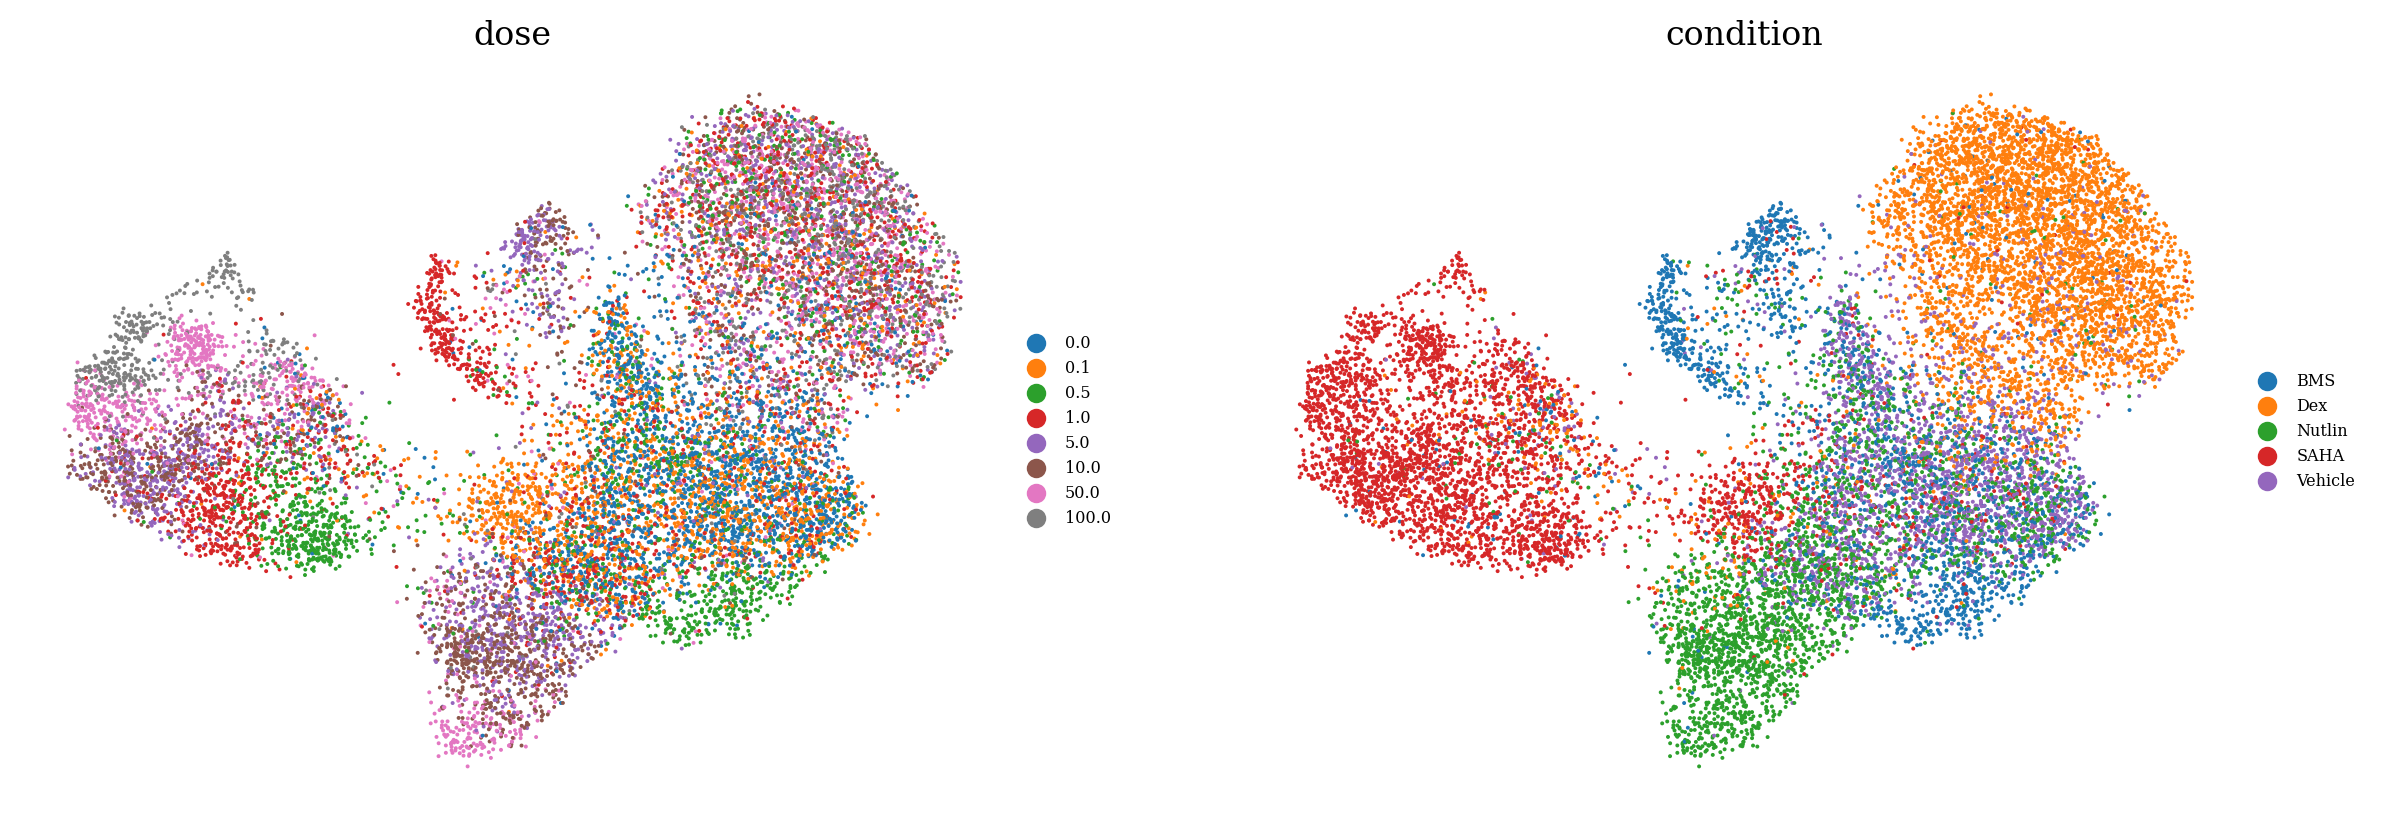

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

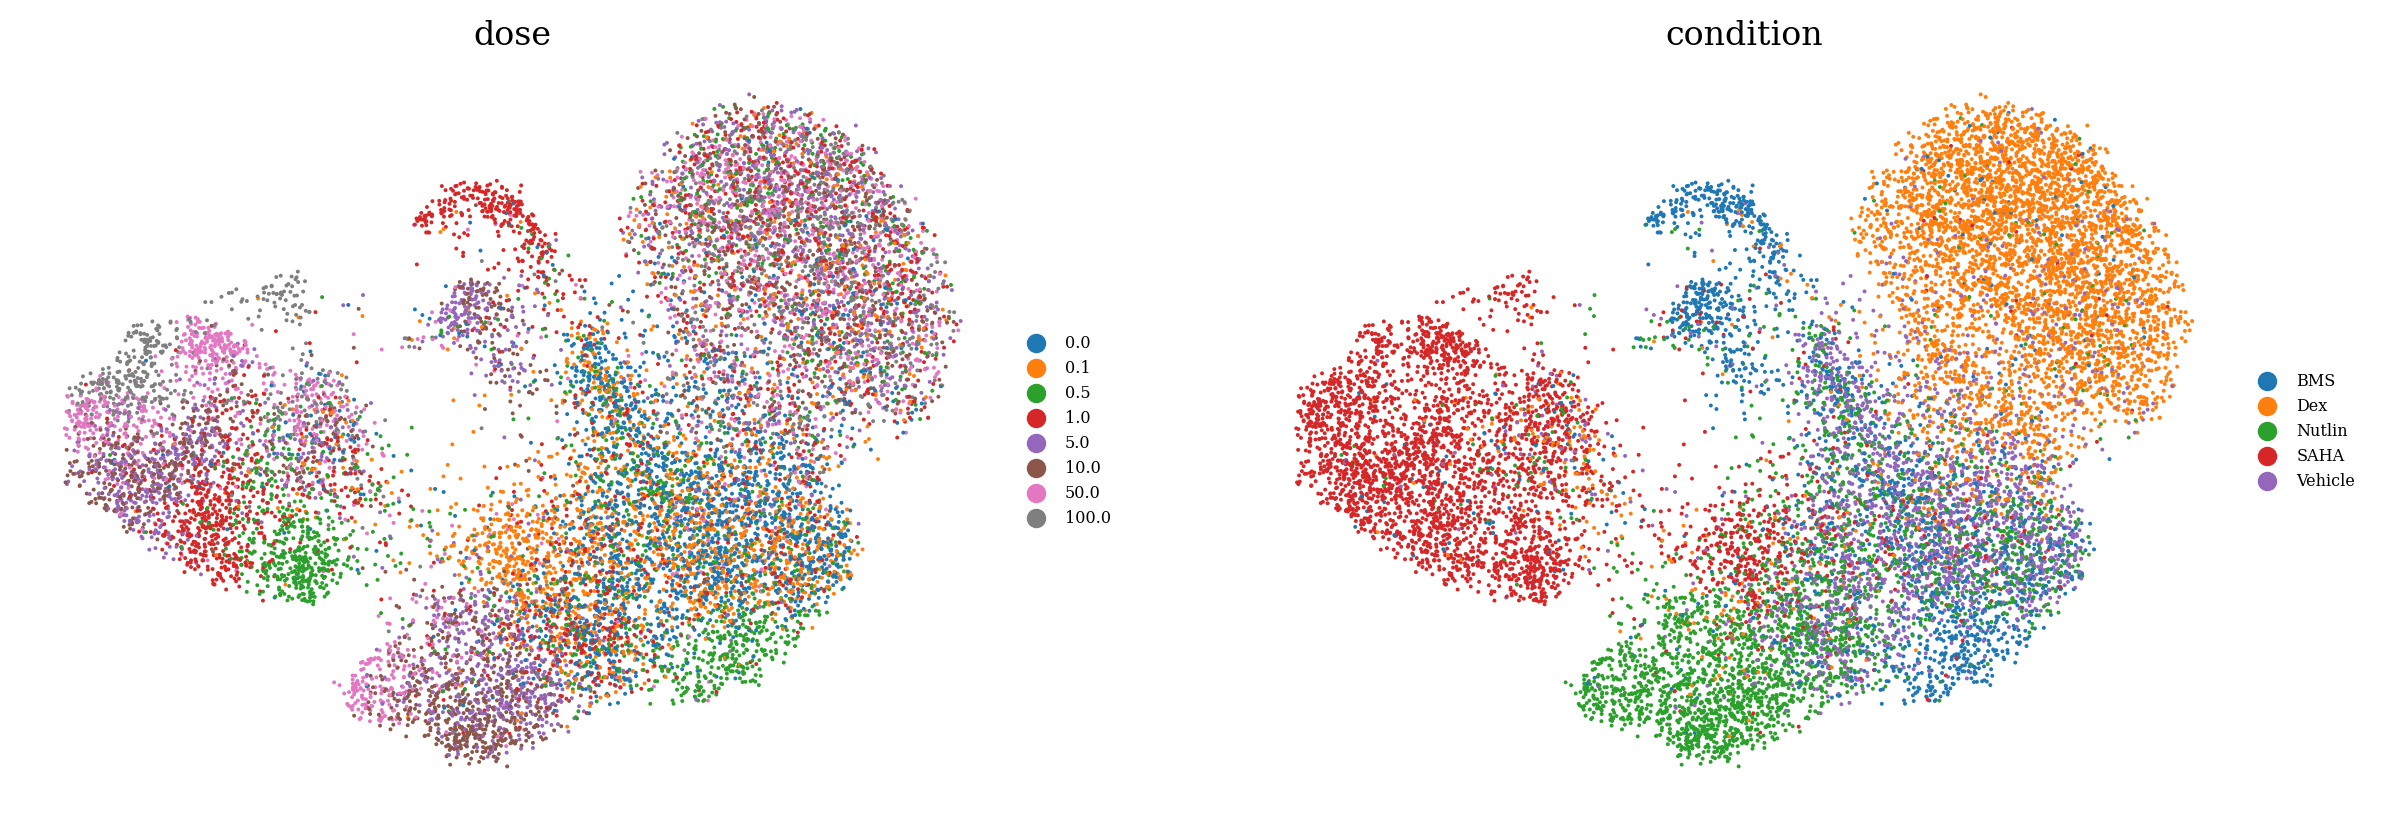

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  4%|▍         | 18/463 [00:00<00:02, 176.96it/s]

  9%|▉         | 43/463 [00:00<00:01, 215.18it/s]

 14%|█▍        | 67/463 [00:00<00:01, 224.16it/s]

 20%|█▉        | 91/463 [00:00<00:01, 228.72it/s]

 25%|██▍       | 115/463 [00:00<00:01, 231.58it/s]

 30%|███       | 139/463 [00:00<00:01, 233.63it/s]

 35%|███▌      | 163/463 [00:00<00:01, 234.75it/s]

 40%|████      | 187/463 [00:00<00:01, 235.29it/s]

 46%|████▌     | 211/463 [00:00<00:01, 236.67it/s]

 51%|█████     | 235/463 [00:01<00:00, 237.04it/s]

 56%|█████▌    | 259/463 [00:01<00:00, 237.23it/s]

 61%|██████    | 283/463 [00:01<00:00, 236.95it/s]

 66%|██████▋   | 307/463 [00:01<00:00, 237.38it/s]

 71%|███████▏  | 331/463 [00:01<00:00, 237.15it/s]

 77%|███████▋  | 355/463 [00:01<00:00, 237.71it/s]

 82%|████████▏ | 379/463 [00:01<00:00, 237.28it/s]

 87%|████████▋ | 403/463 [00:01<00:00, 237.33it/s]

 92%|█████████▏| 427/463 [00:01<00:00, 237.85it/s]

 97%|█████████▋| 451/463 [00:02<00:00, 184.80it/s]

100%|██████████| 463/463 [00:02<00:00, 223.16it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9896259058340179

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)